In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm
from math import sqrt
import pathlib
import os

import sys
sys.path.insert(0, '../utils')
import modelutils
from settings import *

%load_ext autoreload
%autoreload 2

/home/issa/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## File Locations

In [2]:
dirs = [model_dir, scaler_dir, preds_dir]
for dir_ in dirs:
    with pathlib.Path(dir_) as path:
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)
dirs

['../data/models/', '../data/scalers/', '../data/predictions/']

## Indicators and Features

In [3]:
features = poi_features + satellite_features
print(indicators, features)

['perc_hh_no_water_supply', 'perc_hh_no_toilet', 'perc_hh_no_sewage'] ['nearest_waterway', 'nearest_commercial', 'nearest_restaurant', 'nearest_hospital', 'nearest_airport', 'nearest_highway', 'vegetation', 'aridity_cgiarv2', 'temperature', 'nighttime_lights', 'population', 'elevation', 'urban_index']


## Prepare Dataset

In [4]:
raw = pd.read_csv(data_dir + '20200826_dataset.csv').query(
        "aridity_cgiarv2 > -2e9"
      ).dropna(subset = ['adm1_name'] + indicators + features)
raw.head(3)

,pixelated_urban_area_id,id,geometry,perc_hh_no_toilet,perc_hh_no_water_supply,perc_hh_no_sewage,d_mc_basur,d_mc_aguac,d_mc_freq_,d_mc_pare,...,lag_temperature,lag_nighttime_lights,lag_population,lag_elevation,lag_urban_index,lag_nearest_highway,nighttime_lights_area_mean,x,y,urbanity
0,862.0,417475,"POLYGON((-75.5123828117681 5.05751500688412, -...",0.018677,0.020431,0.030647,0.029925,0.150449,0.793726,0.221855,...,14980.00001,47.137354,75.599635,2032.50001,31.37501,381.252504,23.124894,-75.507891,5.062007,u
1,83.0,187318,"POLYGON((-76.4376475501431 7.23143798441016, -...",0.190164,0.213115,0.209836,0.062295,0.409836,0.760656,0.501639,...,15023.68751,0.483760,1.064785,175.37501,6.87501,727.636400,0.808125,-76.433156,7.235930,u
2,409.0,38960,"POLYGON((-75.4854333533688 10.3665583115033, -...",0.006185,0.011875,0.020534,0.011009,0.131989,0.017071,0.133721,...,15459.75001,75.432510,74.737785,27.87501,15.12501,1037.960684,73.723395,-75.480942,10.371050,u


## Replicate Results

In [10]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

def model(df):
    clf = RandomForestRegressor(random_state=42)
    areas = ['cundinamarca', 'choc', 'la_guajira', 'nario']

    for indicator in indicators:
        print('\nTarget Variable: {}'.format(indicator))

        avg_metrics = {'corr':[], 'r2_p':[], 'r2_ns':[], 'mae':[], 'rmse':[]}
        y_tests, y_preds = [], []

        for area in areas:        
            train = df.query(f"adm1_name != '{area}'")
            test = df.query(f"adm1_name == '{area}'")

            y_train = train[indicator]
            y_test = test[indicator]

            scaler = RobustScaler()
            scaler.fit(train[features])
            X_train = scaler.transform(train[features])
            X_test = scaler.transform(test[features])

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            metrics = modelutils.calculate_metrics(y_test, y_pred)
            for metric in metrics:
                avg_metrics[metric].append(metrics[metric])

            y_tests.extend(list(y_test))
            y_preds.extend(list(y_pred))

            print(area)
            print('Number of test samples: {}'.format(len(y_test)))
            for key, val in metrics.items():
                print('\t{}: {:.4f}'.format(key, val))
            
            plt.figure(figsize=(4,3))
            plt.scatter(y_pred, y_test, alpha=0.4, color='red')
            plt.plot([0, 1],[0, 1], color='black')
            plt.xlabel('y_pred')
            plt.ylabel('y_test')
            plt.title('{} (r2 = {:.2f})'.format(indicator, metrics['r2_p']))
            plt.show()

        avg_metrics = {key: np.mean(values) for key, values in avg_metrics.items()}

        print('\nAverage Metrics')
        for key, val in avg_metrics.items():
            print('{}: {:.4f}'.format(key, val))

        print('\nConsolidated Metrics')
        consolidated_metrics = modelutils.calculate_metrics(y_tests, y_preds)
        for key, val in consolidated_metrics.items():
            print('{}: {:.4f}'.format(key, val))

        print()

        plt.scatter(y_preds, y_tests, alpha=0.4)
        plt.plot([0, 1],[0, 1], color='black')
        plt.xlabel('y_pred')
        plt.ylabel('y_test')
        plt.title('{} (r2 = {:.2f})'.format(indicator, avg_metrics['r2_p']))
        plt.show()
        
    print()

## Experiment: All


Target Variable: perc_hh_no_water_supply
cundinamarca
Number of test samples: 1855
	corr: 0.2573
	r2_p: 0.0662
	r2_ns: -0.0820
	mae: 0.1581
	rmse: 0.2450


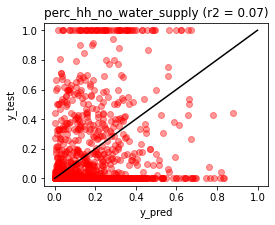

choc
Number of test samples: 287
	corr: 0.1757
	r2_p: 0.0309
	r2_ns: -0.4580
	mae: 0.3787
	rmse: 0.4159


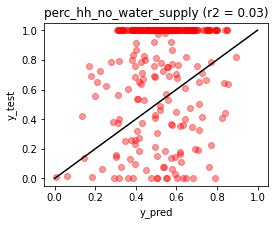

la_guajira
Number of test samples: 283
	corr: 0.3557
	r2_p: 0.1265
	r2_ns: 0.0683
	mae: 0.3027
	rmse: 0.3778


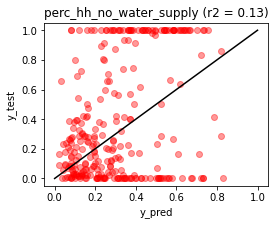

nario
Number of test samples: 378
	corr: 0.7515
	r2_p: 0.5648
	r2_ns: 0.4794
	mae: 0.2041
	rmse: 0.3023


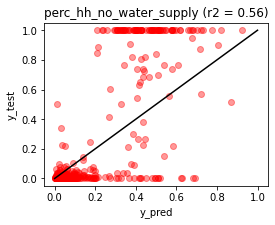


Average Metrics
corr: 0.3850
r2_p: 0.1971
r2_ns: 0.0019
mae: 0.2609
rmse: 0.3353

Consolidated Metrics
corr: 0.5906
r2_p: 0.3488
r2_ns: 0.3454
mae: 0.2015
rmse: 0.2901



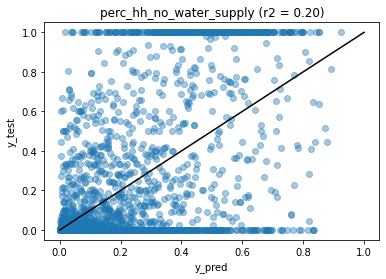


Target Variable: perc_hh_no_toilet
cundinamarca
Number of test samples: 1855
	corr: 0.2421
	r2_p: 0.0586
	r2_ns: -1.3148
	mae: 0.2065
	rmse: 0.2886


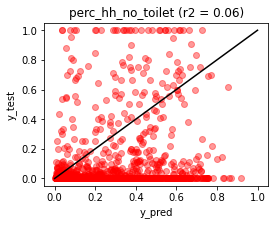

choc
Number of test samples: 287
	corr: 0.1613
	r2_p: 0.0260
	r2_ns: -0.9264
	mae: 0.4117
	rmse: 0.4905


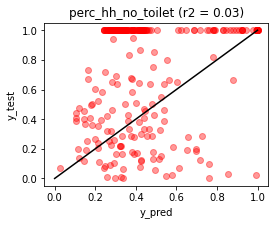

la_guajira
Number of test samples: 283
	corr: 0.8132
	r2_p: 0.6613
	r2_ns: 0.4899
	mae: 0.2218
	rmse: 0.3172


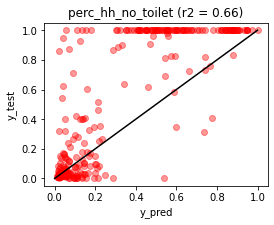

nario
Number of test samples: 378
	corr: 0.8354
	r2_p: 0.6979
	r2_ns: 0.5204
	mae: 0.2046
	rmse: 0.2965


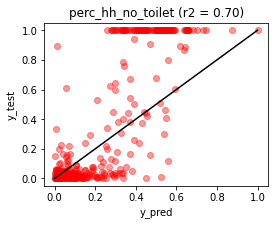


Average Metrics
corr: 0.5130
r2_p: 0.3610
r2_ns: -0.3077
mae: 0.2612
rmse: 0.3482

Consolidated Metrics
corr: 0.5154
r2_p: 0.2657
r2_ns: 0.2401
mae: 0.2288
rmse: 0.3190



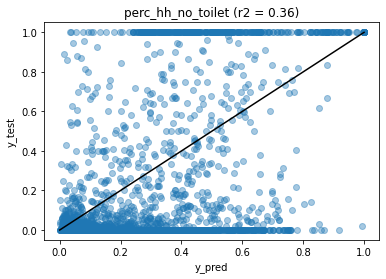


Target Variable: perc_hh_no_sewage
cundinamarca
Number of test samples: 1855
	corr: 0.2016
	r2_p: 0.0407
	r2_ns: -1.3641
	mae: 0.2445
	rmse: 0.3128


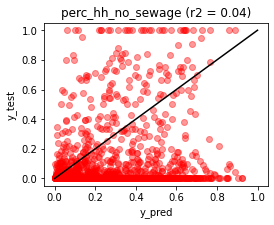

choc
Number of test samples: 287
	corr: 0.3219
	r2_p: 0.1036
	r2_ns: -0.4056
	mae: 0.2801
	rmse: 0.3292


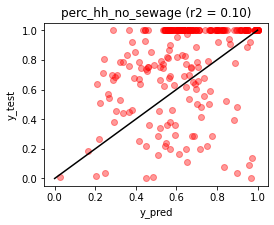

la_guajira
Number of test samples: 283
	corr: 0.5956
	r2_p: 0.3547
	r2_ns: 0.3273
	mae: 0.2725
	rmse: 0.3363


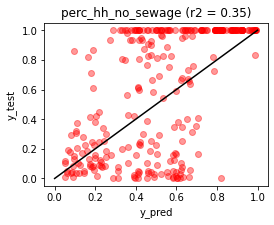

nario
Number of test samples: 378
	corr: 0.9077
	r2_p: 0.8239
	r2_ns: 0.7367
	mae: 0.1632
	rmse: 0.2211


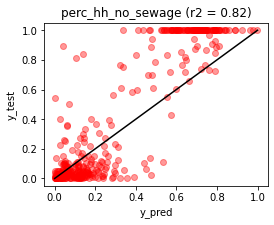


Average Metrics
corr: 0.5067
r2_p: 0.3307
r2_ns: -0.1764
mae: 0.2401
rmse: 0.2999

Consolidated Metrics
corr: 0.6304
r2_p: 0.3975
r2_ns: 0.3433
mae: 0.2400
rmse: 0.3064



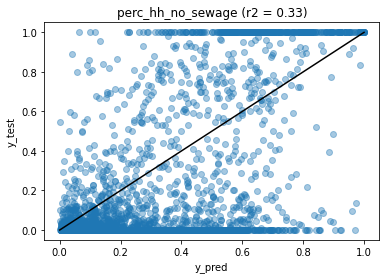

In [11]:
model(raw.copy())

## Experiment: Urban


Target Variable: perc_hh_no_water_supply
cundinamarca
Number of test samples: 642
	corr: 0.2080
	r2_p: 0.0433
	r2_ns: -0.0623
	mae: 0.0414
	rmse: 0.0865


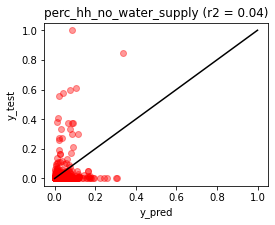

choc
Number of test samples: 113
	corr: 0.0936
	r2_p: 0.0088
	r2_ns: -0.4124
	mae: 0.2692
	rmse: 0.3309


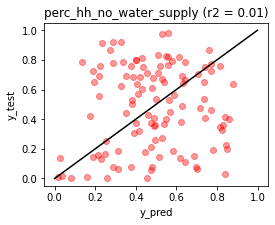

la_guajira
Number of test samples: 144
	corr: 0.2080
	r2_p: 0.0433
	r2_ns: -0.0628
	mae: 0.1793
	rmse: 0.2393


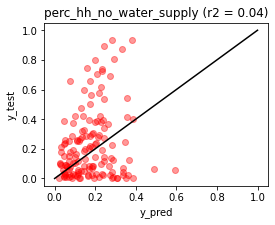

nario
Number of test samples: 271
	corr: 0.8544
	r2_p: 0.7300
	r2_ns: 0.6712
	mae: 0.0729
	rmse: 0.1337


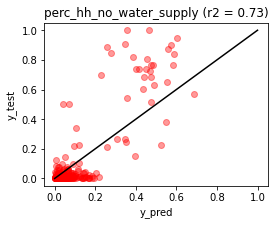


Average Metrics
corr: 0.3410
r2_p: 0.2063
r2_ns: 0.0334
mae: 0.1407
rmse: 0.1976

Consolidated Metrics
corr: 0.6955
r2_p: 0.4837
r2_ns: 0.4797
mae: 0.0877
rmse: 0.1609



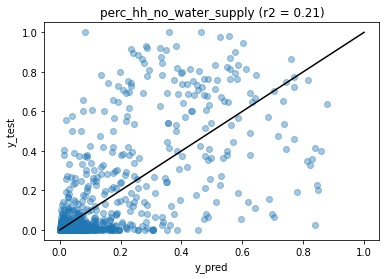


Target Variable: perc_hh_no_toilet
cundinamarca
Number of test samples: 642
	corr: 0.1024
	r2_p: 0.0105
	r2_ns: -0.1918
	mae: 0.0322
	rmse: 0.0646


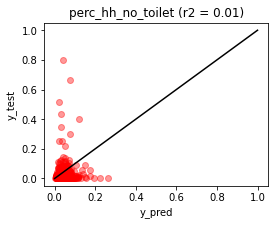

choc
Number of test samples: 113
	corr: 0.1299
	r2_p: 0.0169
	r2_ns: -0.2390
	mae: 0.2070
	rmse: 0.2555


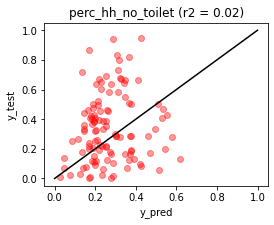

la_guajira
Number of test samples: 144
	corr: 0.2986
	r2_p: 0.0892
	r2_ns: 0.0119
	mae: 0.0795
	rmse: 0.1281


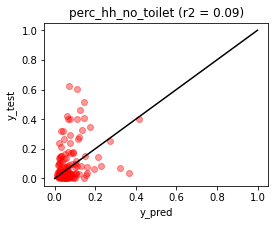

nario
Number of test samples: 271
	corr: 0.7534
	r2_p: 0.5676
	r2_ns: 0.5524
	mae: 0.0671
	rmse: 0.1217


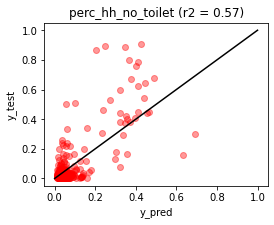


Average Metrics
corr: 0.3211
r2_p: 0.1710
r2_ns: 0.0334
mae: 0.0965
rmse: 0.1424

Consolidated Metrics
corr: 0.6691
r2_p: 0.4477
r2_ns: 0.4453
mae: 0.0630
rmse: 0.1185



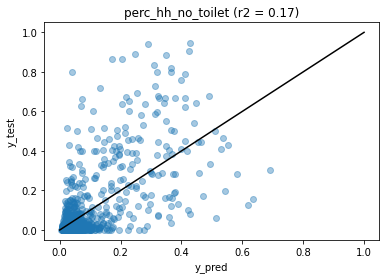


Target Variable: perc_hh_no_sewage
cundinamarca
Number of test samples: 642
	corr: 0.2208
	r2_p: 0.0487
	r2_ns: -0.0933
	mae: 0.0943
	rmse: 0.1549


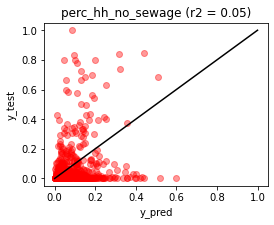

choc
Number of test samples: 113
	corr: 0.1655
	r2_p: 0.0274
	r2_ns: -0.2570
	mae: 0.2544
	rmse: 0.2981


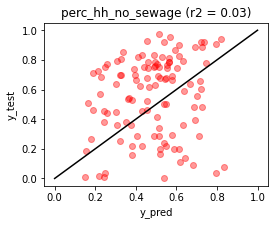

la_guajira
Number of test samples: 144
	corr: 0.2639
	r2_p: 0.0696
	r2_ns: -0.2169
	mae: 0.2635
	rmse: 0.3110


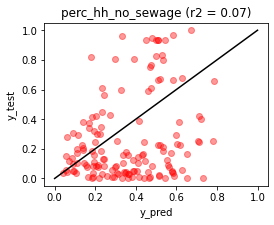

nario
Number of test samples: 271
	corr: 0.8414
	r2_p: 0.7079
	r2_ns: 0.7051
	mae: 0.0946
	rmse: 0.1460


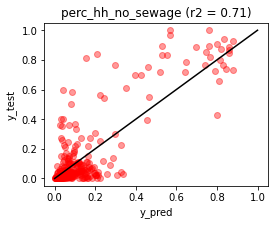


Average Metrics
corr: 0.3729
r2_p: 0.2134
r2_ns: 0.0345
mae: 0.1767
rmse: 0.2275

Consolidated Metrics
corr: 0.6565
r2_p: 0.4310
r2_ns: 0.4156
mae: 0.1307
rmse: 0.1965



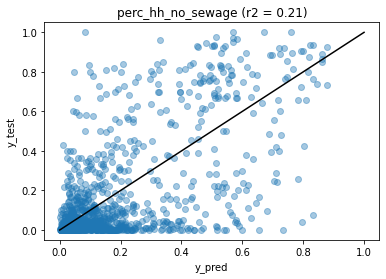

In [12]:
model(raw.query("urbanity == 'u'"))

## Experiment: Rural


Target Variable: perc_hh_no_water_supply
cundinamarca
Number of test samples: 1213
	corr: 0.1472
	r2_p: 0.0217
	r2_ns: -0.2137
	mae: 0.2380
	rmse: 0.3029


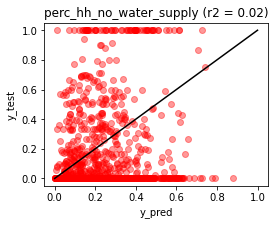

choc
Number of test samples: 174
	corr: 0.1130
	r2_p: 0.0128
	r2_ns: -0.5618
	mae: 0.2453
	rmse: 0.3270


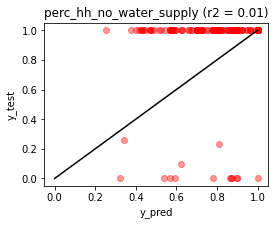

la_guajira
Number of test samples: 139
	corr: 0.2649
	r2_p: 0.0702
	r2_ns: -0.0160
	mae: 0.4106
	rmse: 0.4582


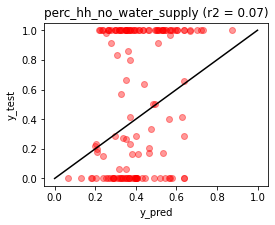

nario
Number of test samples: 107
	corr: 0.2999
	r2_p: 0.0899
	r2_ns: -0.1432
	mae: 0.4076
	rmse: 0.4428


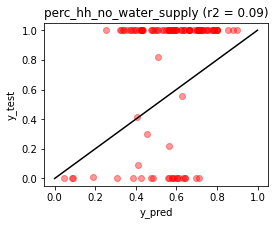


Average Metrics
corr: 0.2063
r2_p: 0.0486
r2_ns: -0.2337
mae: 0.3254
rmse: 0.3827

Consolidated Metrics
corr: 0.5928
r2_p: 0.3514
r2_ns: 0.3490
mae: 0.2646
rmse: 0.3321



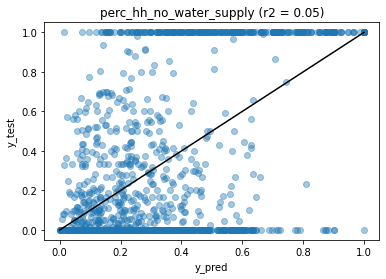


Target Variable: perc_hh_no_toilet
cundinamarca
Number of test samples: 1213
	corr: 0.1687
	r2_p: 0.0285
	r2_ns: -2.8226
	mae: 0.4063
	rmse: 0.4439


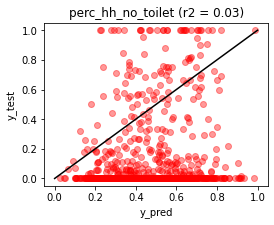

choc
Number of test samples: 174
	corr: 0.1811
	r2_p: 0.0328
	r2_ns: -1.2637
	mae: 0.0432
	rmse: 0.1306


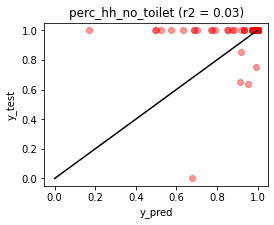

la_guajira
Number of test samples: 139
	corr: 0.2637
	r2_p: 0.0695
	r2_ns: -0.7056
	mae: 0.1576
	rmse: 0.2405


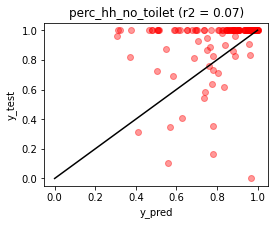

nario
Number of test samples: 107
	corr: 0.7798
	r2_p: 0.6081
	r2_ns: 0.2760
	mae: 0.0905
	rmse: 0.1665


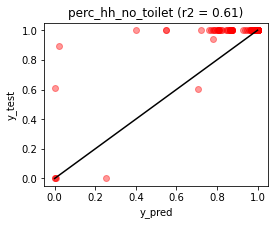


Average Metrics
corr: 0.3483
r2_p: 0.1847
r2_ns: -1.1290
mae: 0.1744
rmse: 0.2454

Consolidated Metrics
corr: 0.7336
r2_p: 0.5382
r2_ns: 0.1796
mae: 0.3258
rmse: 0.3936



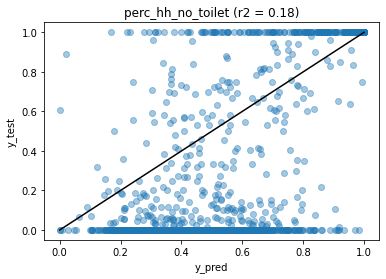


Target Variable: perc_hh_no_sewage
cundinamarca
Number of test samples: 1213
	corr: 0.1687
	r2_p: 0.0285
	r2_ns: -2.8226
	mae: 0.4063
	rmse: 0.4439


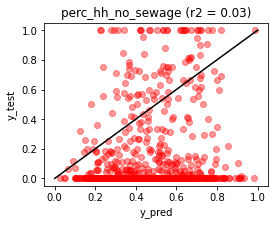

choc
Number of test samples: 174
	corr: 0.1811
	r2_p: 0.0328
	r2_ns: -1.2637
	mae: 0.0432
	rmse: 0.1306


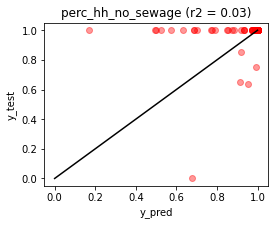

la_guajira
Number of test samples: 139
	corr: 0.2637
	r2_p: 0.0695
	r2_ns: -0.7056
	mae: 0.1576
	rmse: 0.2405


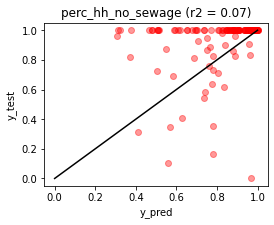

nario
Number of test samples: 107
	corr: 0.7798
	r2_p: 0.6081
	r2_ns: 0.2760
	mae: 0.0905
	rmse: 0.1665


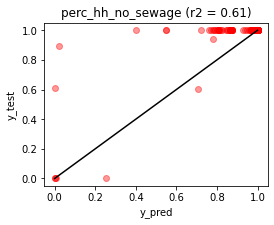


Average Metrics
corr: 0.3483
r2_p: 0.1847
r2_ns: -1.1290
mae: 0.1744
rmse: 0.2454

Consolidated Metrics
corr: 0.7336
r2_p: 0.5382
r2_ns: 0.1796
mae: 0.3258
rmse: 0.3936



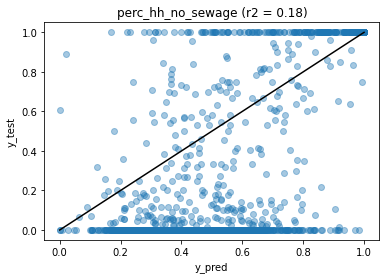

In [13]:
model(raw.query("urbanity == 'r'"))